In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.14/09


In [3]:
infile_r = None  # input file handle

pufiles = ['root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_SingleNeutrino_PU200/SingleNeutrino/CRAB3/190416_160207/0000/ntuple_SingleNeutrino_PU200_%i.root' % (i+1) for i in xrange(63)]

jobs = [0,1,2,3,4,5]

nevents_per_job = 8000

def define_collections(tree):
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return

def load_minbias_batch(j):
  infile = pufiles[j]
  print('[INFO] Opening file: %s' % infile)
  global infile_r
  infile_r = root_open(infile)
  tree = infile_r.ntupler.tree
  define_collections(tree)
  return tree

In [4]:
from six.moves import range, zip, map, filter

kDT, kCSC, kRPC, kGEM, kME0 = 0, 1, 2, 3, 4

nlayers = 16  # 5 (CSC) + 4 (RPC) + 3 (GEM) + 4 (DT)

nsectors = 12

# Num of chambers
# - CSC : 45
# - RPC : 36
# - GEM : 9
# - iRPC: 6
# - ME0 : 3
nchambers = 99

def find_endsec(endcap, sector):
  endsec = (sector - 1) if endcap == 1 else (sector - 1 + 6)
  return endsec

In [5]:
# Main analysis

def analysis():
  # Count CSC&ME0 LCTs; 6 jobs, 8000 events per job, 12 sectors, 99 chambers per sector
  counts = np.zeros((len(jobs),nevents_per_job,nsectors,nchambers), dtype=np.int32)

  # Loop over jobs
  for jobid in jobs:
    # Load tree
    tree = load_minbias_batch(jobid)

    # Event range
    maxEvents = -1

    # __________________________________________________________________________
    # Loop over events
    for ievt, evt in enumerate(tree):
      if maxEvents != -1 and ievt == maxEvents:
        break

      if (ievt % 1000 == 0):  print("Processing event: {0}".format(ievt))

      for ihit, hit in enumerate(evt.hits):
        if hit.bx == 0 and hit.neighbor == 0:
          endsec = find_endsec(hit.endcap, hit.sector)
          csc_id = int(hit.cscid-1)
          my_csc_id = 999999

          # CSC: 0-44
          if hit.type == kCSC:
            if hit.station == 1 and hit.subsector == 1:
              my_csc_id = csc_id
            elif hit.station == 1 and hit.subsector == 2:
              my_csc_id = 9 + csc_id
            elif hit.station == 2:
              my_csc_id = 18 + csc_id
            elif hit.station == 3:
              my_csc_id = 27 + csc_id
            elif hit.station == 4:
              my_csc_id = 36 + csc_id
          # RPC: 45-80
          elif hit.type == kRPC and not ((hit.station == 3 or hit.station == 4) and (hit.ring == 1)) and not ((hit.station == 1 or hit.station == 2) and (hit.ring == 3)):
            if hit.station == 1 and hit.ring == 2 and hit.subsector == 1:
              my_csc_id = 45 + (csc_id - 3)
            elif hit.station == 1 and hit.ring == 2 and hit.subsector == 2:
              my_csc_id = 48 + (csc_id - 3)
            elif hit.station == 2 and hit.ring == 2:
              my_csc_id = 51 + (csc_id - 3)
            elif hit.station == 3 and hit.ring == 2:
              my_csc_id = 57 + (csc_id - 3)
            elif hit.station == 3 and hit.ring == 3:
              my_csc_id = 63 + (csc_id - 3)
            elif hit.station == 4 and hit.ring == 2:
              my_csc_id = 69 + (csc_id - 3)
            elif hit.station == 4 and hit.ring == 3:
              my_csc_id = 75 + (csc_id - 3)
          # GEM: 81-89
          elif hit.type == kGEM:
            if hit.station == 1 and hit.ring == 1 and hit.subsector == 1:
              my_csc_id = 81 + csc_id
            elif hit.station == 1 and hit.ring == 1 and hit.subsector == 2:
              my_csc_id = 84 + csc_id
            elif hit.station == 2 and hit.ring == 1:
              my_csc_id = 87 + csc_id
          # iRPC: 90-95
          elif hit.type == kRPC and ((hit.station == 3 or hit.station == 4) and (hit.ring == 1)):
            if hit.station == 3:
              my_csc_id = 90 + csc_id
            elif hit.station == 4:
              my_csc_id = 93 + csc_id
          # ME0 (|eta|<2.4): 96-98
          elif hit.type == kME0 and (hit.emtf_theta >= 4):
            if hit.station == 1:
              my_csc_id = 96 + csc_id

          # Sanity check
          if hit.type == kCSC:
            assert(0 <= my_csc_id < 45)
          elif hit.type == kRPC and not ((hit.station == 3 or hit.station == 4) and (hit.ring == 1)) and not ((hit.station == 1 or hit.station == 2) and (hit.ring == 3)):
            assert(45 <= my_csc_id < 81)
          elif hit.type == kGEM:
            assert(81 <= my_csc_id < 90)
          elif hit.type == kRPC and ((hit.station == 3 or hit.station == 4) and (hit.ring == 1)):
            assert(90 <= my_csc_id < 96)
          elif hit.type == kME0 and (hit.emtf_theta >= 4):
            assert(96 <= my_csc_id < 99)

          if my_csc_id != 999999:
            counts[jobid, ievt, endsec, my_csc_id] += 1
      # End loop over evt.hits
    # End loop over events
  # End loop over jobs
  
  print("DONE")
  return counts

In [6]:
%%time

# Run analysis
counts = analysis()

[INFO] Opening file: root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_SingleNeutrino_PU200/SingleNeutrino/CRAB3/190416_160207/0000/ntuple_SingleNeutrino_PU200_1.root
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
[INFO] Opening file: root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_SingleNeutrino_PU200/SingleNeutrino/CRAB3/190416_160207/0000/ntuple_SingleNeutrino_PU200_2.root
Processing event: 0
Processing event: 1000
Processing event: 2000
Processing event: 3000
Processing event: 4000
Processing event: 5000
Processing event: 6000
Processing event: 7000
[INFO] Opening file: root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_SingleNeutrino_PU200/SingleNeutrino/CRAB3/190416_160207/0000/ntuple_SingleNeutrino_PU200_3.root
Processing event: 0
Processin

In [7]:
print counts.shape, counts.dtype

(6, 8000, 12, 99) int32


In [8]:
# Styling
plt.style.use('tdrstyle.mplstyle')

0 (48000, 72)
1 (48000, 72)
2 (48000, 36)
3 (48000, 36)
4 (48000, 36)
5 (48000, 72)
6 (48000, 72)
7 (48000, 36)
8 (48000, 36)
9 (48000, 72)
10 (48000, 36)
11 (48000, 36)


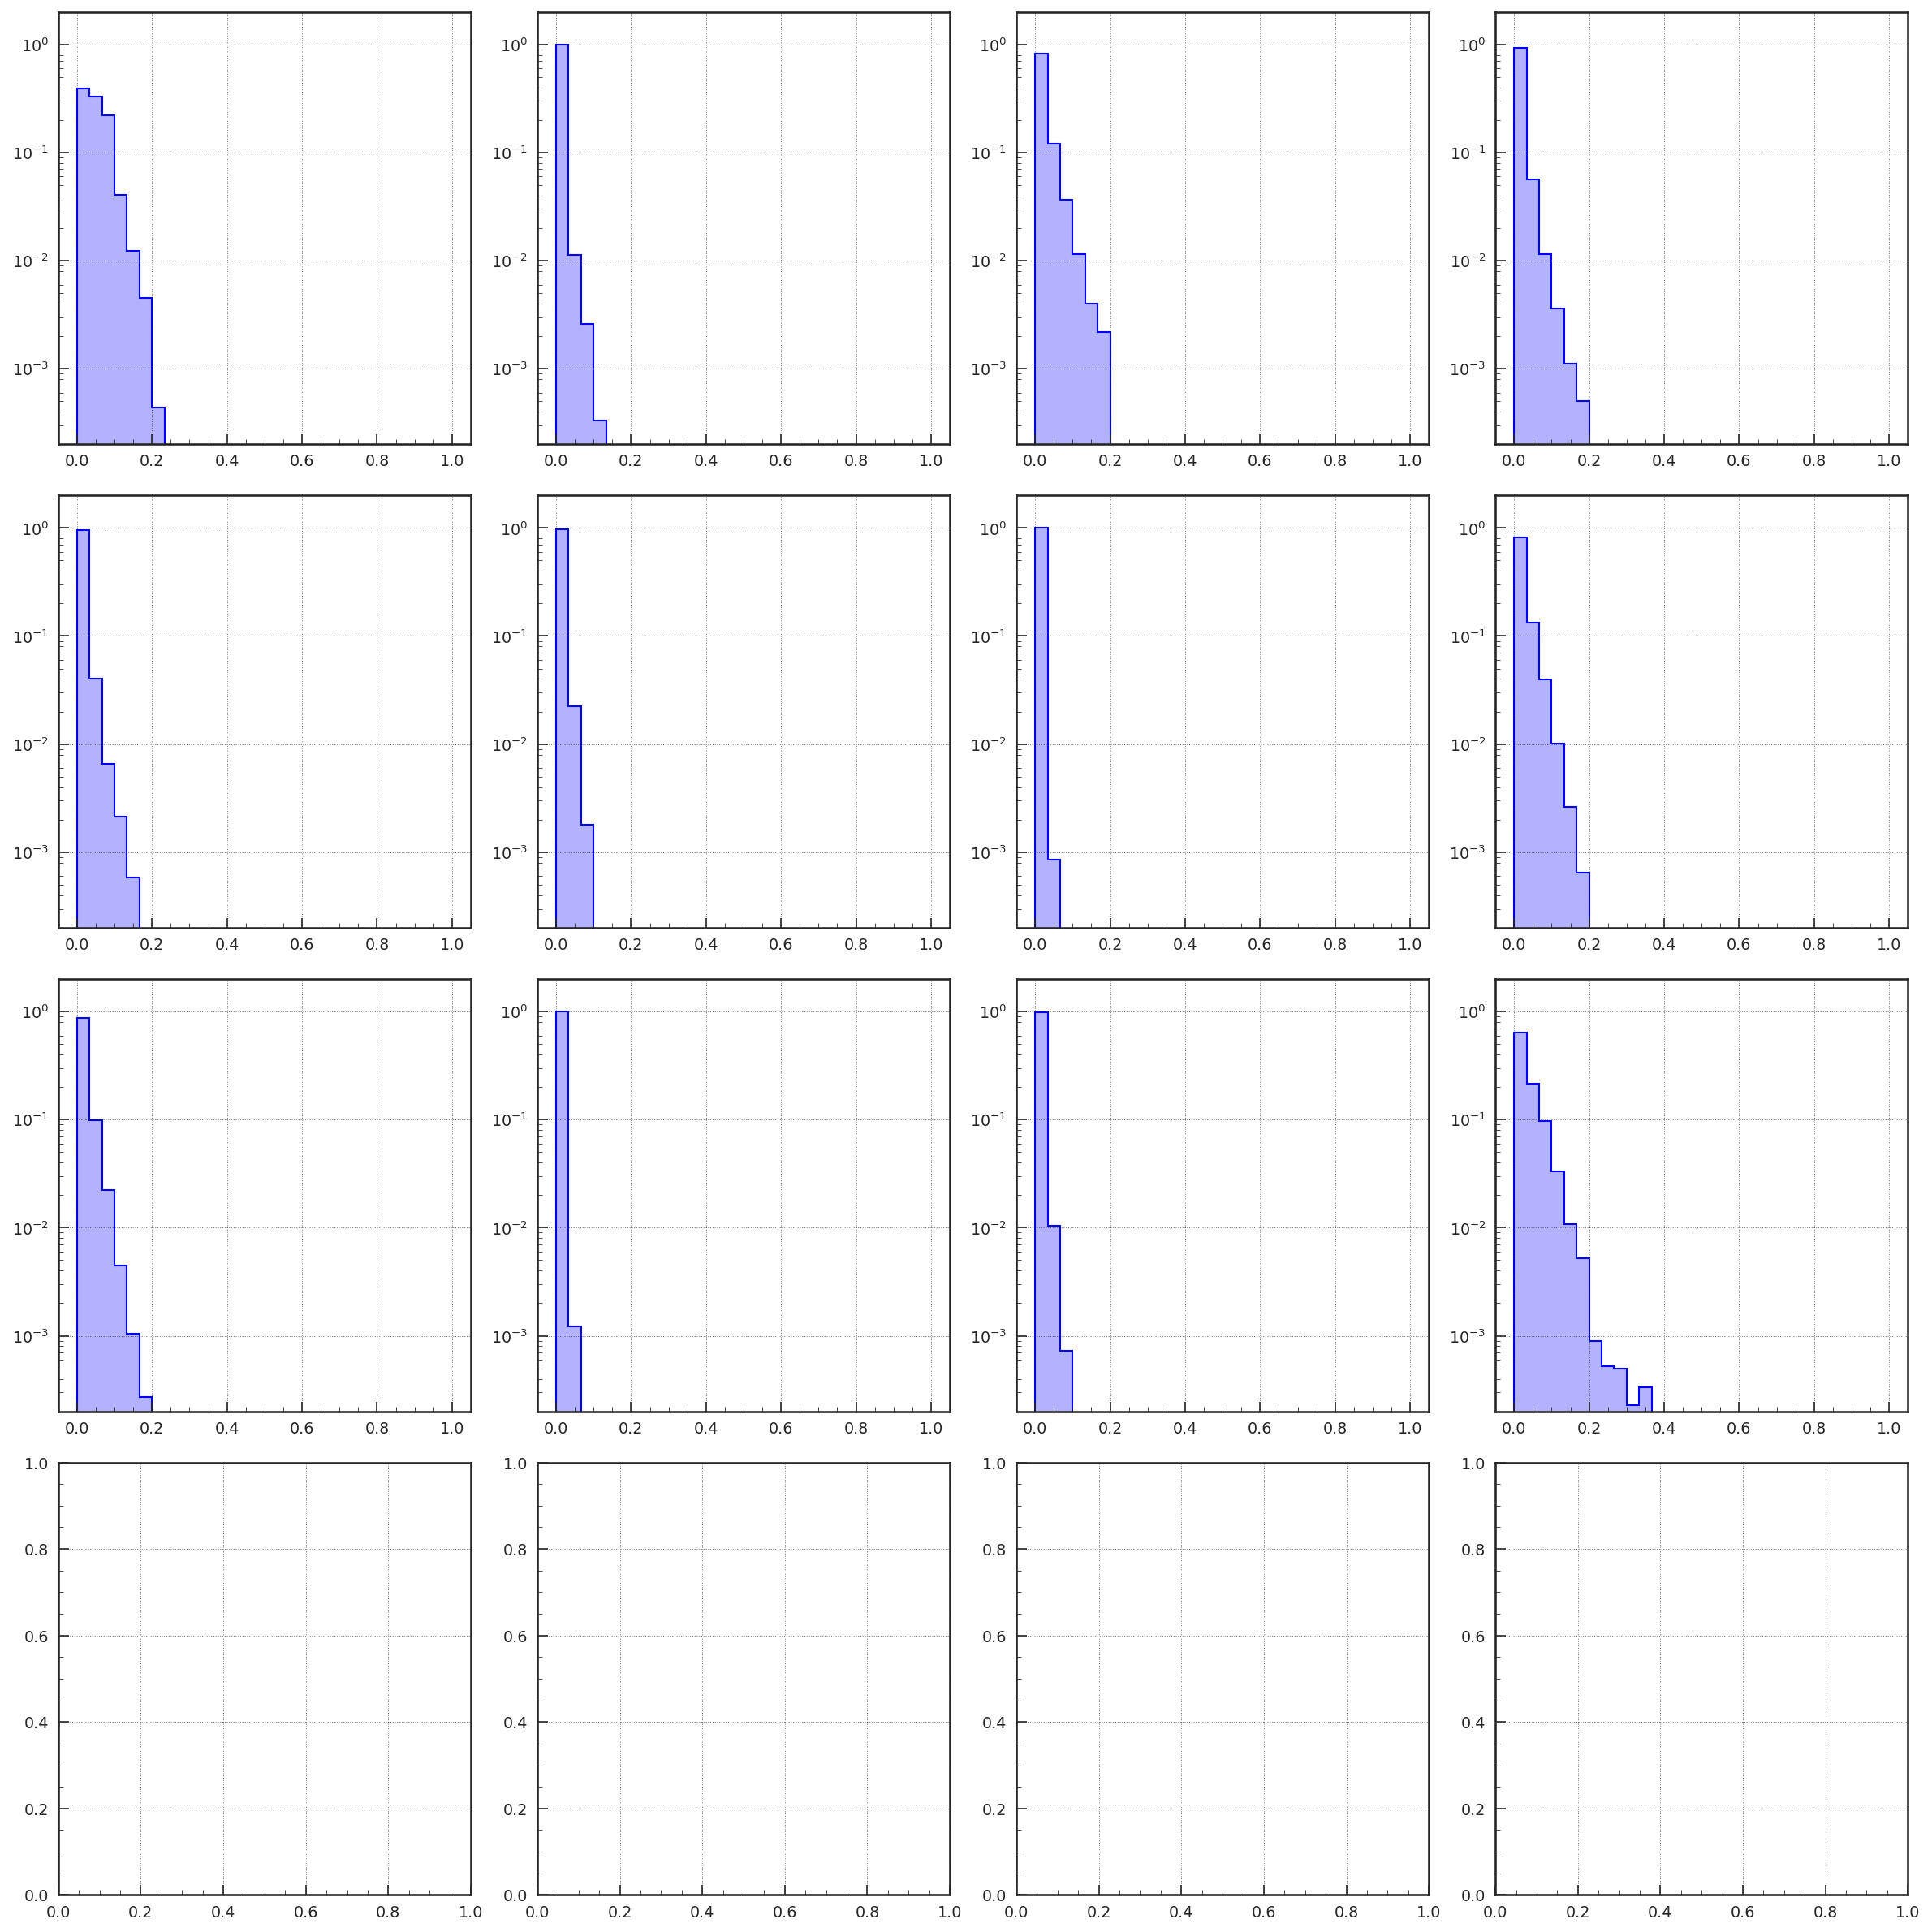

In [16]:
fig, axs = plt.subplots(nlayers/4, 4, figsize=(4*4,(nlayers/4)*4), tight_layout=True)

for i in xrange(nlayers):
  if i == 0:    # ME1/1
    counts_tmp_0 = counts[:,:,:,0:0+3]
    counts_tmp_1 = counts[:,:,:,9:9+3]
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 1:  # ME1/2
    counts_tmp_0 = counts[:,:,:,0+3:0+3+3]
    counts_tmp_1 = counts[:,:,:,9+3:9+3+3]
    counts_tmp = np.concatenate((counts_tmp_0, counts_tmp_1), axis=-1)
  elif i == 2:  # ME2/1
    counts_tmp = counts[:,:,:,18:18+3]
  elif i == 3:  # ME3/1
    counts_tmp = counts[:,:,:,27:27+3]
  elif i == 4:  # ME4/1
    counts_tmp = counts[:,:,:,36:36+3]
  elif i == 5:  # RE1/2
    counts_tmp = counts[:,:,:,45:45+6]
  elif i == 6:  # RE2/2
    counts_tmp = counts[:,:,:,51:51+6]
  elif i == 7:  # RE3/1
    counts_tmp = counts[:,:,:,90:90+3]
  elif i == 8:  # RE4/1
    counts_tmp = counts[:,:,:,93:93+3]
  elif i == 9:  # GE1/1
    counts_tmp = counts[:,:,:,81:81+6]
  elif i == 10: # GE2/1
    counts_tmp = counts[:,:,:,87:87+3]
  elif i == 11: # ME0
    counts_tmp = counts[:,:,:,96:96+3]
  else:
    continue

  # Avg occupancy
  x = counts_tmp.reshape(len(jobs)*nevents_per_job, -1)
  print i, x.shape
  x = x.mean(axis=1)

  # Draw
  ax = axs[i/4,i%4]
  w = np.ones_like(x)/float(len(x))
  hist, edges, _ = ax.hist(x, bins=30, range=(0.,1.), weights=w, histtype='step', color='b', linewidth=1)
  hist, edges, _ = ax.hist(x, bins=30, range=(0.,1.), weights=w, histtype='stepfilled', color='b', alpha=0.3)
  ax.set_yscale('log')
  ax.set_ylim(2e-4, 2e0)

plt.show()